In [62]:
# Imports and loading data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

df = pd.read_csv("steel.csv")
df.head()

,normalising_temperature,tempering_temperature,percent_silicon,percent_chromium,percent_copper,percent_nickel,percent_sulphur,percent_carbon,percent_manganese,tensile_strength
0,178.500,275,0.1530,0.970575,0.942,0.8870,0.0,1.920,0.0,25.107613
1,178.500,950,0.1530,1.212726,0.942,0.8870,0.0,1.920,0.0,140.035334
2,178.500,375,0.1530,1.621165,0.942,0.8870,0.0,1.920,0.0,42.217650
3,178.500,900,0.1530,0.809989,0.942,0.8870,0.0,1.920,0.0,95.015309
4,189.525,900,0.1624,1.036229,0.849,0.9382,0.0,2.035,0.0,113.266773


In [63]:
# Define features and target vairables
target_col = 'tensile_strength'
X = df.drop(columns=[target_col]).values
y = df[target_col].values
feature_names = df.drop(columns=[target_col]).columns.tolist()

print("Features:", feature_names)
print("Target:", target_col)

Features: ['normalising_temperature', 'tempering_temperature', 'percent_silicon', 'percent_chromium', 'percent_copper', 'percent_nickel', 'percent_sulphur', 'percent_carbon', 'percent_manganese']
Target: tensile_strength


In [64]:
# metrics to compare performance
# RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
# MAPE
def mape(y_true, y_pred):
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

In [65]:
# Experimental setup
RANDOM_STATE = 42
n_splits = 10
outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

In [66]:
# Default RFR
rf_default = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=1
)

results_default = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scaling features  
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Train default RFR
    rf_default.fit(X_train_s, y_train)

    # Predictions
    y_train_pred = rf_default.predict(X_train_s)
    y_test_pred = rf_default.predict(X_test_s)

    # Check RMSE and MAPE
    results_default.append({
        'train_rmse': rmse(y_train, y_train_pred),
        'test_rmse': rmse(y_test, y_test_pred),
        'train_mape': mape(y_train, y_train_pred),
        'test_mape': mape(y_test, y_test_pred)
    })

# Summary table for default RFR
df_rf_default = pd.DataFrame(results_default)
display(df_rf_default)

# %matplotlib inline needed for display not working
summary_rf_default = df_rf_default.agg(['mean', 'std']).T
print("\nDefault Random Forest Averages:")
display(summary_rf_default)

,train_rmse,test_rmse,train_mape,test_mape
0,11.142486,29.469903,5.494718,18.474158
1,11.345121,27.183563,5.319342,12.984641
2,11.110018,26.030787,5.214582,12.405952
3,11.315080,24.165296,5.457373,9.696113
4,10.583881,32.876818,5.097921,14.785660
5,10.850718,22.694676,5.126409,12.191052
6,11.170730,31.838054,5.317354,16.523374
7,10.634581,30.976195,4.996063,15.464545
8,10.383807,34.099235,5.153949,16.334586
9,10.876687,23.545794,5.066969,11.838133



Default Random Forest Averages:


,mean,std
train_rmse,10.941311,0.328188
test_rmse,28.288032,4.124980
train_mape,5.224468,0.167526
test_mape,14.069821,2.678942


In [67]:
# Tuned RFR with n_estimators and max_depth
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15, 20]
}

results_tuned = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Grid Search CV
    gs_rf = GridSearchCV(
        estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1),
        param_grid=param_grid_rf,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        refit=True
    )

    gs_rf.fit(X_train_s, y_train)
    best_rf = gs_rf.best_estimator_

    # Training predictions
    y_train_pred = best_rf.predict(X_train_s)
    y_test_pred = best_rf.predict(X_test_s)

    results_tuned.append({
        'best_params': gs_rf.best_params_,
        'train_rmse': rmse(y_train, y_train_pred),
        'test_rmse': rmse(y_test, y_test_pred),
        'train_mape': mape(y_train, y_train_pred),
        'test_mape': mape(y_test, y_test_pred)
    })

# Summary table for tuned RFR

df_rf_tuned = pd.DataFrame(results_tuned)
display(df_rf_tuned)

summary_rf_tuned = df_rf_tuned.drop(columns=['best_params']).agg(['mean', 'std']).T
print("\nTuned Random Forest Averages:")
display(summary_rf_tuned)

# Best hyperparameter frequency
best_counts = Counter(tuple(sorted(d.items())) for d in df_rf_tuned['best_params'])
formatted = {
    ", ".join(f"{k}={v}" for k, v in combo): count
    for combo, count in best_counts.items()
}

print("\nBest hyperparameters frequency acros folds:")
for combo, count in formatted.items():
    print(f"{combo}: {count} fold(s)")

,best_params,train_rmse,test_rmse,train_mape,test_mape
0,"{'max_depth': 10, 'n_estimators': 150}",12.714116,30.215090,6.311535,18.457468
1,"{'max_depth': 20, 'n_estimators': 200}",11.028181,26.565856,5.190882,12.591591
2,"{'max_depth': None, 'n_estimators': 100}",11.110018,26.030787,5.214582,12.405952
3,"{'max_depth': 20, 'n_estimators': 50}",11.463896,23.999435,5.343241,9.607129
4,"{'max_depth': 10, 'n_estimators': 200}",11.738023,33.129076,5.766418,14.683298
5,"{'max_depth': 15, 'n_estimators': 50}",11.199679,22.936280,5.213265,11.759811
6,"{'max_depth': None, 'n_estimators': 50}",11.365487,31.736318,5.319406,16.420346
7,"{'max_depth': 10, 'n_estimators': 200}",11.919699,31.951498,5.860927,16.366375
8,"{'max_depth': 20, 'n_estimators': 150}",10.303907,34.076297,5.125181,16.067914
9,"{'max_depth': None, 'n_estimators': 150}",10.878333,23.829449,5.051884,11.993528



Tuned Random Forest Averages:


,mean,std
train_rmse,11.372134,0.653604
test_rmse,28.447009,4.225393
train_mape,5.439732,0.405687
test_mape,14.035341,2.767345



Best hyperparameters frequency acros folds:
max_depth=10, n_estimators=150: 1 fold(s)
max_depth=20, n_estimators=200: 1 fold(s)
max_depth=None, n_estimators=100: 1 fold(s)
max_depth=20, n_estimators=50: 1 fold(s)
max_depth=10, n_estimators=200: 2 fold(s)
max_depth=15, n_estimators=50: 1 fold(s)
max_depth=None, n_estimators=50: 1 fold(s)
max_depth=20, n_estimators=150: 1 fold(s)
max_depth=None, n_estimators=150: 1 fold(s)


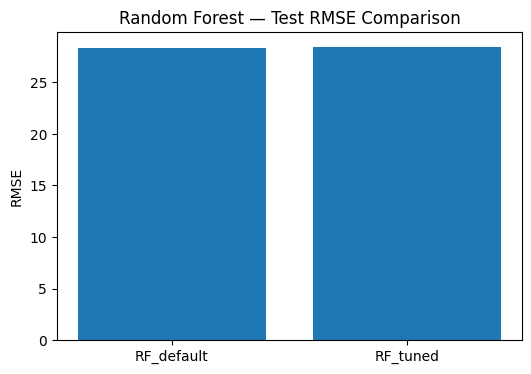

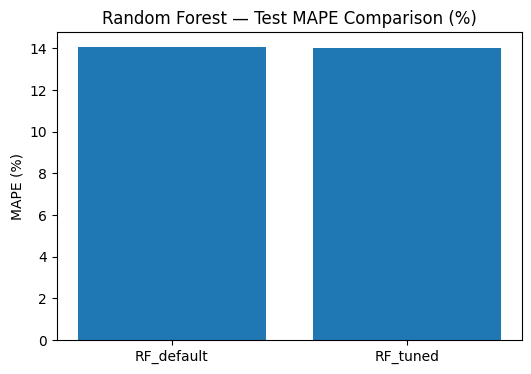

In [68]:
#Charts for RMSE and MAPE
models = ['RF_default', 'RF_tuned']

rmse_vals = [
    summary_rf_default.loc['test_rmse','mean'],
    summary_rf_tuned.loc['test_rmse','mean']
]

mape_vals = [
    summary_rf_default.loc['test_mape','mean'],
    summary_rf_tuned.loc['test_mape','mean']
]

# RMSE
plt.figure(figsize=(6,4))
plt.bar(models, rmse_vals)
plt.title("Random Forest — Test RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

# MAPE
plt.figure(figsize=(6,4))
plt.bar(models, mape_vals)
plt.title("Random Forest — Test MAPE Comparison (%)")
plt.ylabel("MAPE (%)")
plt.show()

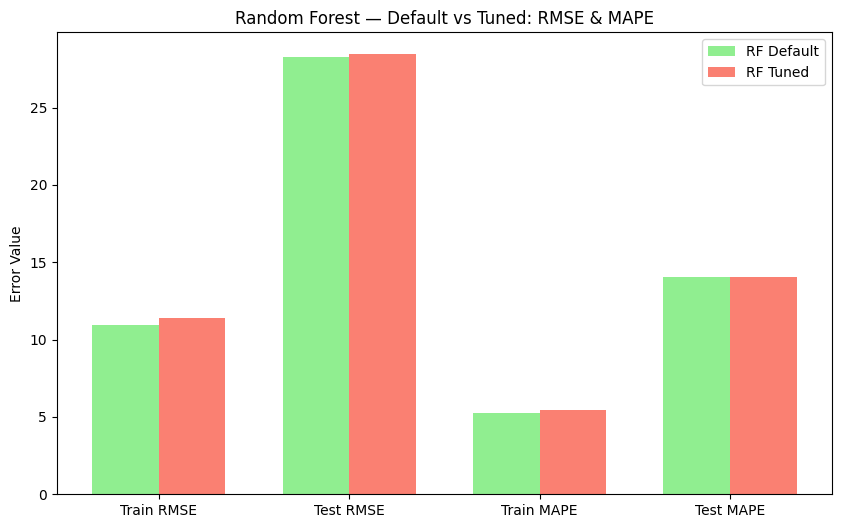

In [ ]:
labels = ['Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE']

#. default and tuned values
rfr_default_vals = [
    df_rf_default['train_rmse'].mean(),
    df_rf_default['test_rmse'].mean(),
    df_rf_default['train_mape'].mean(),
    df_rf_default['test_mape'].mean()
]
rfr_tuned_vals = [
    df_rf_tuned['train_rmse'].mean(),
    df_rf_tuned['test_rmse'].mean(),
    df_rf_tuned['train_mape'].mean(),
    df_rf_tuned['test_mape'].mean()
]

# x positions for bars
x = np.arange(len(labels))
width = 0.35


plt.figure(figsize=(10,6))
plt.bar(x - width/2, rfr_default_vals, width, label='RF Default', color='lightgreen')
plt.bar(x + width/2, rfr_tuned_vals, width, label='RF Tuned', color='salmon')
plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Random Forest — Default vs Tuned: RMSE & MAPE")
plt.legend()
plt.show()